In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=aaa1550903d86afd5fde52b30b448ee179449ae5c47231111a457e1885fab662
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [39]:
import numpy as np
import torch
from medmnist import OrganAMNIST
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# images to tensors
initial_transform = transforms.Compose([
    transforms.ToTensor()
])

#  Loading the dataset with transformation
train_dataset_raw = OrganAMNIST(split="train", download=True, transform=initial_transform)
val_dataset_raw = OrganAMNIST(split="val", transform=initial_transform)
test_dataset_raw = OrganAMNIST(split="test", transform=initial_transform)


#  DataLoader with batchsize=1 to iterate over individual images
train_loader_raw = DataLoader(train_dataset_raw, batch_size=1)

# Initialize variables to compute mean and std
mean_sum = 0.0
std_sum = 0.0
num_samples = len(train_dataset_raw)

for data, _ in train_loader_raw:
    data = data.float()
    mean_sum += data.mean()
    std_sum += data.std()

mean = mean_sum / num_samples
std = std_sum / num_samples

print(f"Computed mean: {mean.item()}, std: {std.item()}")

#  transformation with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])
])

# Re-load the datasets with the normalization
train_dataset = OrganAMNIST(split="train", transform=transform)
val_dataset = OrganAMNIST(split="val", transform=transform)
test_dataset = OrganAMNIST(split="test", transform=transform)

# func to adjust labels to have  correct shape
class AdjustLabelsDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        # Convert labels to tensor and remove extra dimensions
        y = torch.tensor(y).long().squeeze()
        return X, y

# Wrap  datasets
train_dataset = AdjustLabelsDataset(train_dataset)
val_dataset = AdjustLabelsDataset(val_dataset)
test_dataset = AdjustLabelsDataset(test_dataset)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the first batch
X_batch, y_batch = next(iter(train_loader))
print(f"X_batch shape: {X_batch.shape}")           # Should be [batch_size, C, H, W]
print(f"y_batch shape: {y_batch.shape}")           # Should be [batch_size]
print(f"y_batch dtype: {y_batch.dtype}")           # Should be torch.int64

print("Data prepared and loaders created!")

# Move the batch to the device
X_batch = X_batch.to(device)
y_batch = y_batch.to(device)






Using downloaded and verified file: /root/.medmnist/organamnist.npz
Computed mean: 0.4680284559726715, std: 0.2471543252468109
X_batch shape: torch.Size([64, 1, 28, 28])
y_batch shape: torch.Size([64])
y_batch dtype: torch.int64
Data prepared and loaders created!


In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, input_size, num_classes=11, use_pooling=False, conv_layers_config=None, fc_units=256):
        super(Net, self).__init__()
        if conv_layers_config is None:
            conv_layers_config = [
                {'in_channels': 1, 'out_channels': 32, 'kernel_size': 3, 'padding': 1},
                {'in_channels': 32, 'out_channels': 64, 'kernel_size': 3, 'padding': 1}
            ]

        self.use_pooling = use_pooling
        self.conv_layers = nn.ModuleList()

        # Build convolutional layers
        for conv_cfg in conv_layers_config:
            conv_layer = nn.Conv2d(
                in_channels=conv_cfg['in_channels'],
                out_channels=conv_cfg['out_channels'],
                kernel_size=conv_cfg.get('kernel_size', 3),
                padding=conv_cfg.get('padding', 0)
            )
            self.conv_layers.append(conv_layer)

        # Pooling layer (optional)
        self.pool = nn.MaxPool2d(2, 2) if use_pooling else None

        # Calculate the size of the flattened feature map
        self.feature_map_size = self._get_feature_map_size(input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_map_size, fc_units)
        self.fc2 = nn.Linear(fc_units, num_classes)

    def _get_feature_map_size(self, input_size):
        # Simulate passing a dummy input through the convolutional layers
        with torch.no_grad():
            x = torch.zeros(1, 1, input_size, input_size)
            for conv_layer in self.conv_layers:
                x = F.relu(conv_layer(x))
                if self.pool:
                    x = self.pool(x)
            feature_map_size = x.numel()
        return feature_map_size

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = F.relu(conv_layer(x))
            if self.pool:
                x = self.pool(x)
        x = x.view(-1, self.feature_map_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [41]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, save_path='best_model.pth'):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Initialize lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Initialize variable to track the lowest validation loss
    best_val_loss = float('inf')  # Set to infinity initially

    for epoch in range(num_epochs):
        ###################
        # Training Phase
        ###################
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Record loss
            running_loss += loss.item() * inputs.size(0)

            # Record accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        ####################
        # Validation Phase
        ####################
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient computation
            for val_inputs, val_labels in val_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                # Record loss
                val_running_loss += val_loss.item() * val_inputs.size(0)

                # Record accuracy
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        ####################
        # Saving the Best Model
        ####################
        # Check if the current validation loss is lower than the best recorded
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss  # Update the best validation loss
            torch.save(model.state_dict(), save_path)  # Save the model's state_dict
            print(f'--> New best model saved with validation loss: {best_val_loss:.4f}')

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train Accuracy: {epoch_train_accuracy:.2f}%, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {epoch_val_accuracy:.2f}%')

    print("Training complete.")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best model saved to {save_path}")

    # Return the recorded metrics
    return train_losses, train_accuracies, val_losses, val_accuracies

In [42]:
# Model for Step 6
input_size = 28
model6 = Net(input_size=input_size, use_pooling=False, fc_units=256)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=0.001)
num_epochs = 20


save_path = 'best.pth'

# Call the train function
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model6,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    save_path=save_path
)

--> New best model saved with validation loss: 0.1487
Epoch [1/20], Train Loss: 0.2829, Train Accuracy: 91.24%, Val Loss: 0.1487, Val Accuracy: 95.67%
Epoch [2/20], Train Loss: 0.0304, Train Accuracy: 99.01%, Val Loss: 0.1657, Val Accuracy: 95.87%
Epoch [3/20], Train Loss: 0.0157, Train Accuracy: 99.52%, Val Loss: 0.1561, Val Accuracy: 96.29%
Epoch [4/20], Train Loss: 0.0050, Train Accuracy: 99.86%, Val Loss: 0.1624, Val Accuracy: 96.89%
Epoch [5/20], Train Loss: 0.0053, Train Accuracy: 99.83%, Val Loss: 0.3175, Val Accuracy: 94.10%
Epoch [6/20], Train Loss: 0.0154, Train Accuracy: 99.50%, Val Loss: 0.1518, Val Accuracy: 96.81%
Epoch [7/20], Train Loss: 0.0080, Train Accuracy: 99.76%, Val Loss: 0.1665, Val Accuracy: 96.23%
Epoch [8/20], Train Loss: 0.0029, Train Accuracy: 99.91%, Val Loss: 0.1687, Val Accuracy: 96.90%
Epoch [9/20], Train Loss: 0.0036, Train Accuracy: 99.90%, Val Loss: 0.2214, Val Accuracy: 96.98%
Epoch [10/20], Train Loss: 0.0110, Train Accuracy: 99.71%, Val Loss: 0.23

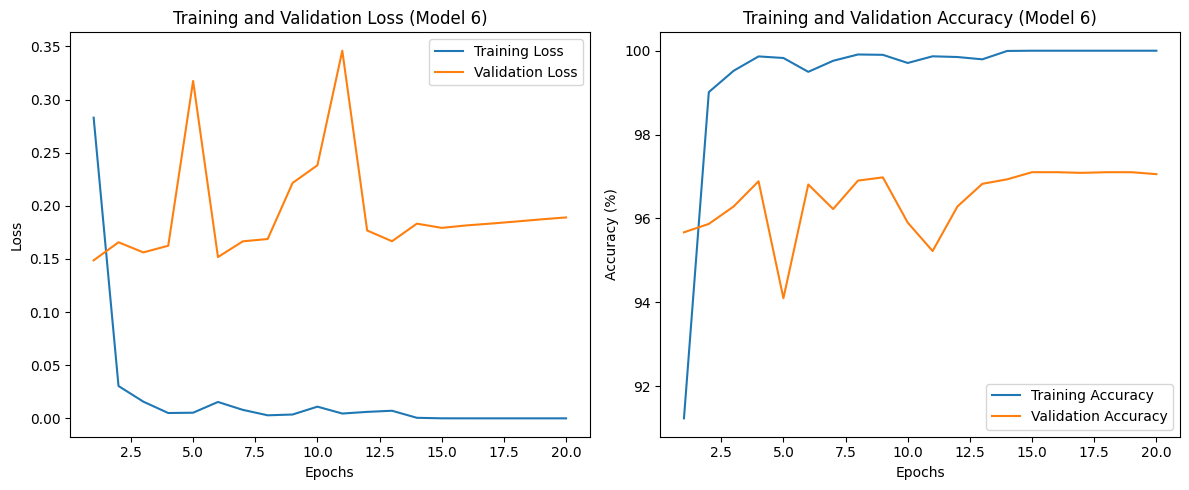

In [43]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model 6)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
model6.load_state_dict(torch.load('best.pth'))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model6.to(device)

# Set the model to evaluation mode
model6.eval()


# Initialize variables for evaluation
test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model6(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_epoch_loss = test_running_loss / len(test_loader.dataset)
test_epoch_accuracy = 100 * test_correct / test_total

print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%')

<ipython-input-44-9efa456ac5c4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model6.load_state_dict(torch.load('best.pth'))


Test Loss: 0.5953, Test Accuracy: 83.55%


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# images to tensors
initial_transform = transforms.Compose([
    transforms.ToTensor()
])

#  Loading the dataset with transformation
train_dataset_raw = OrganAMNIST(split="train", download=True, transform=initial_transform,size = 128)
val_dataset_raw = OrganAMNIST(split="val", transform=initial_transform,size = 128)
test_dataset_raw = OrganAMNIST(split="test", transform=initial_transform,size = 128)


#  DataLoader with batchsize=1 to iterate over individual images
train_loader_raw = DataLoader(train_dataset_raw, batch_size=1)

# Initialize variables to compute mean and std
mean_sum = 0.0
std_sum = 0.0
num_samples = len(train_dataset_raw)

for data, _ in train_loader_raw:
    data = data.float()
    mean_sum += data.mean()
    std_sum += data.std()

mean = mean_sum / num_samples
std = std_sum / num_samples

print(f"Computed mean: {mean.item()}, std: {std.item()}")

#  transformation with normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()])
])

# Re-load the datasets with the normalization
train_dataset = OrganAMNIST(split="train", transform=transform,size =128)
val_dataset = OrganAMNIST(split="val", transform=transform,size = 128)
test_dataset = OrganAMNIST(split="test", transform=transform, size = 128)

# func to adjust labels to have  correct shape
class AdjustLabelsDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        X, y = self.dataset[idx]
        # Convert labels to tensor and remove extra dimensions
        y = torch.tensor(y).long().squeeze()
        return X, y

# Wrap  datasets
train_dataset = AdjustLabelsDataset(train_dataset)
val_dataset = AdjustLabelsDataset(val_dataset)
test_dataset = AdjustLabelsDataset(test_dataset)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the first batch
X_batch, y_batch = next(iter(train_loader))
print(f"X_batch shape: {X_batch.shape}")           # Should be [batch_size, C, H, W]
print(f"y_batch shape: {y_batch.shape}")           # Should be [batch_size]
print(f"y_batch dtype: {y_batch.dtype}")           # Should be torch.int64

print("Data prepared and loaders created!")

# Move the batch to the device
X_batch = X_batch.to(device)
y_batch = y_batch.to(device)


Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Computed mean: 0.4680313169956207, std: 0.23491597175598145
X_batch shape: torch.Size([64, 1, 128, 128])
y_batch shape: torch.Size([64])
y_batch dtype: torch.int64
Data prepared and loaders created!


In [46]:
model7 = Net(
    input_size=128,
    use_pooling=True,  # Include pooling layers
    conv_layers_config=[
        {'in_channels': 1, 'out_channels': 32, 'kernel_size': 3, 'padding': 1},
        {'in_channels': 32, 'out_channels': 64, 'kernel_size': 3, 'padding': 1},
        {'in_channels': 64, 'out_channels': 128, 'kernel_size': 3, 'padding': 1}
    ],
    fc_units=256
)

In [47]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model7.to(device)


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model7.parameters(), lr=0.001)
num_epochs = 20


save_path = 'best_7.pth'

# Call the train function
train_losses_7, train_accuracies_7, val_losses_7, val_accuracies_7 = train(
    model=model7,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    save_path=save_path
)

--> New best model saved with validation loss: 0.0911
Epoch [1/20], Train Loss: 0.2801, Train Accuracy: 90.75%, Val Loss: 0.0911, Val Accuracy: 97.50%
--> New best model saved with validation loss: 0.0816
Epoch [2/20], Train Loss: 0.0378, Train Accuracy: 98.81%, Val Loss: 0.0816, Val Accuracy: 97.80%
Epoch [3/20], Train Loss: 0.0132, Train Accuracy: 99.56%, Val Loss: 0.1522, Val Accuracy: 96.64%
Epoch [4/20], Train Loss: 0.0144, Train Accuracy: 99.55%, Val Loss: 0.1542, Val Accuracy: 97.09%
Epoch [5/20], Train Loss: 0.0131, Train Accuracy: 99.57%, Val Loss: 0.1892, Val Accuracy: 95.50%
Epoch [6/20], Train Loss: 0.0082, Train Accuracy: 99.77%, Val Loss: 0.1708, Val Accuracy: 97.23%
Epoch [7/20], Train Loss: 0.0054, Train Accuracy: 99.85%, Val Loss: 0.1788, Val Accuracy: 96.73%
Epoch [8/20], Train Loss: 0.0091, Train Accuracy: 99.75%, Val Loss: 0.1601, Val Accuracy: 97.21%
Epoch [9/20], Train Loss: 0.0132, Train Accuracy: 99.68%, Val Loss: 0.1327, Val Accuracy: 98.06%
Epoch [10/20], Trai

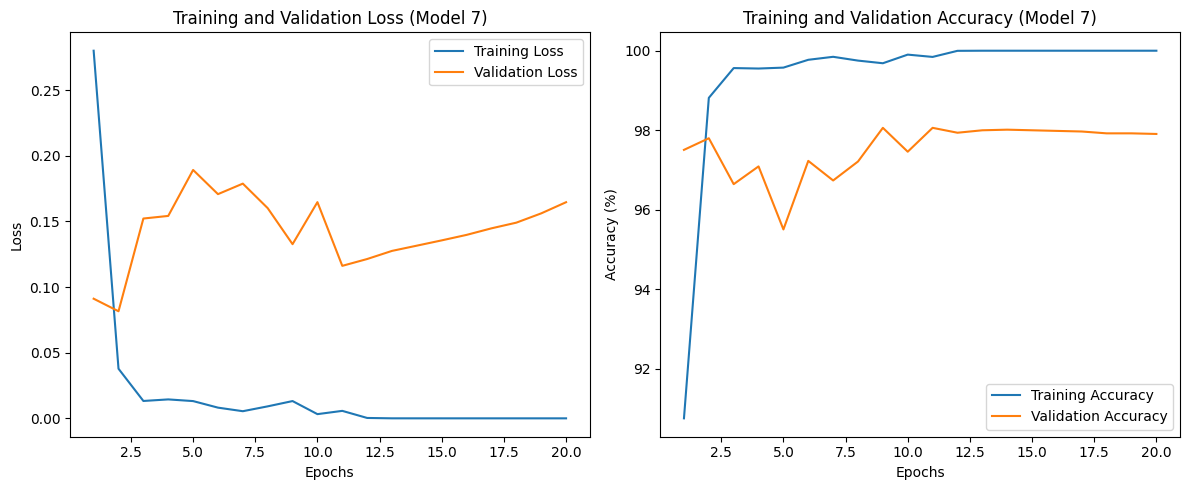

In [48]:
epochs = range(1, num_epochs + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_7, label='Training Loss')
plt.plot(epochs, val_losses_7, label='Validation Loss')
plt.title('Training and Validation Loss (Model 7)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies_7, label='Training Accuracy')
plt.plot(epochs, val_accuracies_7, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Model 7)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [49]:
model7.load_state_dict(torch.load('best_7.pth'))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model6.to(device)

# Set the model to evaluation mode
model7.eval()


# Initialize variables for evaluation
test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model7(inputs)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_epoch_loss = test_running_loss / len(test_loader.dataset)
test_epoch_accuracy = 100 * test_correct / test_total

print(f'Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%')

<ipython-input-49-a03b13367202>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model7.load_state_dict(torch.load('best_7.pth'))


Test Loss: 0.4749, Test Accuracy: 88.14%
